In [30]:
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/drive')
%cd /drive/MyDrive/data/pipotron/
%pwd
%ls -al

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
/drive/MyDrive/data/pipotron
total 100
drwx------ 2 root root  4096 Mar 16 10:48 donnees/
drwx------ 8 root root  4096 Mar 16 10:40 .git/
-rw------- 1 root root  1819 Mar 16 11:10 .gitignore
-rw------- 1 root root  4451 Mar 16 12:39 git.ipynb
drwx------ 3 root root  4096 Mar 16 10:46 models/
-rw------- 1 root root 82075 Mar 17 08:59 pipotron_entrainement.ipynb
-rw------- 1 root root    79 Mar 16 10:40 README.md


In [85]:
# Chargement des données :

from_full_table = False
reviews_filename = "donnees/review_only.txt"

if from_full_table:
  # Chargement du fichier complet, issu du scraping du site larvf.com (données accessibles par abonnement, non publiques):
  DF_rvf = pd.read_csv("/drive/MyDrive/donnees/larvf_2020-11-24.csv")
  print("Nombre de revues textuelles disponibles :", len(DF_rvf)-DF_rvf['review_text'].isna().sum())

  # On sélectionne la colonne qui nous intéresse en retirant les valeurs manquantes, et on fait un mélange aléatoire: 
  S_reviews = DF_rvf['review_text'][~DF_rvf['review_text'].isna()].sample(frac=1, random_state=5406).reset_index(drop=True)
  S_reviews = S_reviews.drop_duplicates()
  print("Nombre de revues textuelles après suppression des doublons :", len(S_reviews))
  display(S_reviews.head(4))
  
  # On enregistre ces données pour ce projet:
  S_reviews.to_csv(reviews_filename, header=False, index=False)

else:
  S_reviews = pd.read_csv(reviews_filename, header=None).iloc[:, 0]
  print("Nombre de revues :", len(S_reviews))
  display(S_reviews.head(4))


Nombre de revues : 30208


0    Cette cuvée a gagné en élégance et en délicate...
1    Bonne trame acide. Légères notes animales à l’...
2    Réservé, à la fois pur et nerveux, il s'appuie...
3    Un assemblage de meunier et chardonnay, pas d’...
Name: 0, dtype: object

In [86]:
# Préparation des données:
import re

# On ajoute un nouveau mot (token) qui a vocation à servir de déclencheur pour générer un nouveau commentaire de dégustation.
# On supprime également les informations de date du commentaire, parfois présentes.
# Enfin on ajoute un token de fin de séquence pour inciter le modèle à produire des commentaires de taille raisonnable.
L_first_tokens = ["<|review|>"]
L_reviews = [L_first_tokens[0] + " " + re.sub(r"\([^\(\)]*\.[0-9][0-9][0-9][0-9]\)", "", review.strip()) for review in list(S_reviews)]
L_reviews = [review + " <|end|>" for review in L_reviews]

# Affichons le résultat de cette préparation sur quelques lignes:
for i in range(27,32):
  print(L_reviews[i])

<|review|> On sent des vignes qui ont du fond dans un vin mûr et structuré, qui reste simple en finale. <|end|>
<|review|> Un véritable jus de caillou croquant et tonique, un vin plein de répartie, singulier dans l'éclat très ferme de son fruit tendu, d'une rare intensité désaltérante et juteuse. <|end|>
<|review|> Il s’exprime sur le fruit noir. Il mêle virilité et élégance, avec une forte empreinte du terroir. <|end|>
<|review|> Derrière une fine réduction, il livre une note d’épices et de garrigue. Il lui faut un peu d’air pour libérer son fruit. Il offre une très belle qualité du fruit, du relief avec une jolie assise tannique mais sans dureté. Long en bouche, il possède un beau potentiel de garde et d’évolution. <|end|>
<|review|> Les vendanges ont été plus tardives qu’à Haut-Brion, mais le vin conserve une réelle fraîcheur et un fruit sapide. Beaucoup de crémeux avec une fine sucrosité et un boisé doux (60 % de bois neuf). Bouche de grand équilibre avec une saveur saline en final

In [87]:
# On vérifie le nombre de lignes:
print(len(L_reviews))

30208


In [88]:
# On va s'appuyer sur un modèle de générateur GPT-2 (merci OpenAI) pré-entraîné sur la langue française (merci Antoine Louis),
# et on utilise la bibliothèque transformers (merci à HuggingFace): 
!pip install transformers
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel
import tensorflow as tf

# On charge le modèle pré-entraîné et son tokenizer associé:
model_name = "antoiloui/belgpt2"
model = TFGPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
nb_added_tokens = 0

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at antoiloui/belgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [89]:
# On ajoute des tokens de déclenchement et de padding au tokenizer, et on prépare le modèle à recevoir ces nouveaux tokens:
nb_added_tokens += tokenizer.add_special_tokens({'pad_token': "<|pad|>", 'eos_token':"<|end|>"})
if len(L_first_tokens)>0:
    nb_added_tokens += tokenizer.add_special_tokens({'additional_special_tokens': L_first_tokens})
print(nb_added_tokens, "token(s) ajoutés")

_ = model.resize_token_embeddings(tokenizer.vocab_size + nb_added_tokens)

3 token(s) ajoutés


In [90]:
# On vérifie la bonne définition des tokens de padding et de fin de séquence :
print(tokenizer.pad_token, ":", tokenizer.pad_token_id)
assert tokenizer.pad_token_id!=None
print(tokenizer.eos_token, ":", tokenizer.eos_token_id)
assert tokenizer.eos_token_id!=None

<|pad|> : 50257
<|end|> : 50258


In [91]:
# On vérifie qu'un commentaire de vin est inchangé après tokenisation puis détokenisation:
i = 4449
print(L_reviews[i])

print(tokenizer.decode(tokenizer.encode(L_reviews[i])))
assert L_reviews[i] == tokenizer.decode(tokenizer.encode(L_reviews[i]))

<|review|> Tilleul est un aligoté ambitieux et dense, mais encore sous l'emprise de son boisé. <|end|>
<|review|> Tilleul est un aligoté ambitieux et dense, mais encore sous l'emprise de son boisé. <|end|>


In [92]:
# On génère un commentaire aléatoire, avant entraînement spécifique (fine tuning) donc non exploitable à ce stade:

# TO DO: optimiser si besoin (?) les paramètres de génération aléatoire 
# cf. https://blog.fastforwardlabs.com/2019/05/29/open-ended-text-generation.html

def pipote(max_length=200, skip_special_tokens=True):
  input = tokenizer.encode(L_first_tokens[0], return_tensors='tf')
  output = model.generate(
      input_ids=input,
      max_length=max_length,
      do_sample=True,
      pad_token_id=tokenizer.pad_token_id 
  )
  return tokenizer.decode(output[0], skip_special_tokens=skip_special_tokens)

print(pipote())

ées, et les chambres sont magnifiques, spacieuses, confortables et équipées de tous les accessoires, la terrasse est magnifique avec le chant des cigales sur le toit. Je tiens à vous confirmer que les autorités de la Ligue des champions se préoccupent des incidents et ne donnent pas l' impression que le championnat se joue sous les projecteurs. Pour la sécurité et la préservation de mon équilibre psychologique. Cela représente entre 6 et 8 milliards pour la France, soit le niveau de la dette publique française de 11,2 % du produit intérieur brut. La maison et son paysage en font une expérience à vivre absolument. En France, l' étude de cas a été réalisée à l' université d' Uppsala, les résultats expérimentaux se sont déroulés sous l' égide du programme national " Airsal Integrated Analysis " issu de l' Institut de l' environnement du LNE ; les résultats issus de l' analyse comparative du modèle en trois dimensions de ce modèle ont été diffusés. De quoi


63.0
27275


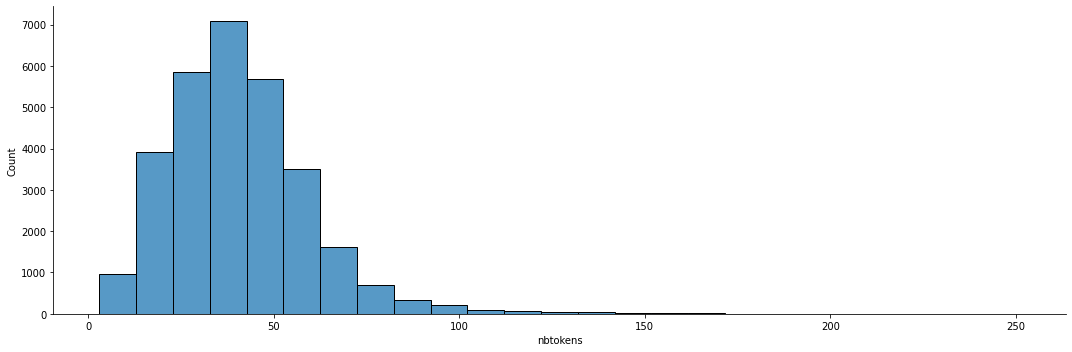

In [93]:
# Pour limiter les calculs inutiles et le besoin de padding, on ne va garder que 90% des revues, celles ayant le plus faible nombre de tokens.
# Le seuil calculé ci-dessous est à 64 tokens. 
# (Pareto est notre ami :-))

import seaborn as sns
unpadded = tokenizer(L_reviews, padding=False)
L_nbtokens = [len(t) for t in unpadded.input_ids]
DF_nbtokens = pd.DataFrame(pd.Series(L_nbtokens, name='nbtokens'))
sns.displot(kind='hist', data=DF_nbtokens, x='nbtokens', bins=25, aspect=3)
threshold = DF_nbtokens.nbtokens.quantile(0.9)
print(threshold)

L_short_reviews = [L_reviews[i] for i in range(0, len(L_reviews)) if L_nbtokens[i]<=threshold]
print(len(L_short_reviews))

In [94]:
# On prépare les données d'entraînement du générateur:
# Le générateur prédit le mot suivant pour chaque mot (ou plutôt token, en l'occurrence wordpiece) du texte fourni en entrée.
# Donc l'ensemble d'apprentissage est constitué de tuples (x=entrée, y=sortie) où y est un décalage de x d'un token vers la droite.

batch_size = 16
train_size = int(0.80*len(L_short_reviews)/batch_size)*batch_size
print("Taille des batches :", batch_size)
print("Nombre de lignes dans la base d'apprentissage :", train_size)

encodings = tokenizer(L_short_reviews, padding=True, return_tensors='tf')
input_ids = encodings.input_ids
attention_mask = encodings.attention_mask
x = {'input_ids': input_ids[:, :-1], 'attention_mask': attention_mask[:, :-1]}
y = input_ids[:, 1:]
assert x['input_ids'].shape == y.shape
assert x['attention_mask'].shape == y.shape
full_dataset = tf.data.Dataset.from_tensor_slices((x, y))
train_dataset = full_dataset.take(train_size).batch(batch_size).repeat()
test_dataset = full_dataset.skip(train_size).batch(batch_size)

Taille des batches : 16
Nombre de lignes dans la base d'apprentissage : 21808


In [95]:
# On "encapsule" le modèle initial dans un modèle qui ne renvoie que les "logit" des probabilités des mots,
# ce à quoi on peut appliquer la fonction de coût classique (entropie croisée)

class Pipotron(tf.keras.Model):
  def __init__(self, model):
    super().__init__(name="Pipotron")
    self.gpt2 = model
  def __call__(self, input, training=False):    
    y = self.gpt2(input, training=training)
    return y.logits

pipotron = Pipotron(model)

In [96]:
# On contrôle les formats d'entrée et de sortie du modèle (à ce stade il est déboussolé par notre token de déclenchement):
for features, labels in train_dataset.take(1):
  i=4
  for k in features.keys():
    print(k, ":", features[k].shape)
  print(tokenizer.decode(features['input_ids'][i], skip_special_tokens=False))
  print("labels :", labels.shape)
  print(tokenizer.decode(labels[i], skip_special_tokens=False))
  z = pipotron(features)
  print("output :", z.shape)
  print(tokenizer.decode(tf.math.argmax(z[i], axis=-1), skip_special_tokens=False))

input_ids : (16, 62)
attention_mask : (16, 62)
<|review|> Un viognier fidèle à son bouquet exubérant, agréable et fluide. <|end|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>
labels : (16, 62)
Un viognier fidèle à son bouquet exubérant, agréable et fluide. <|end|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|> <|pad|>
output : (16, 62, 50260)
' peudeurnier, à son terroi

In [97]:
# Paramétrage de l'entraînement :

# TO DO : appliquer un learning_rate dégressif évolutif ?

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
pipotron.compile(optimizer=optimizer, loss=loss)

In [98]:
# ENTRAINEMENT (fine tuning) DU MODELE :

# Pour voir la progression, on affiche le score à chaque 'round' (pseudo-epoch, qui est en fait une subdivision de la 'vraie' epoch
# si on considère qu'une vraie epoch consiste à passer toute la base d'entraînement une fois):
nb_epochs = 5
nb_steps_per_round = 400
nb_rounds = (nb_epochs*len(L_short_reviews))//(batch_size*nb_steps_per_round)
print("Nombre d'étapes (rounds) d'entraînement prévues :", nb_rounds)
H_history = pipotron.fit(train_dataset, validation_data=test_dataset, epochs=nb_rounds, steps_per_epoch=nb_steps_per_round)

Nombre d'étapes (rounds) d'entraînement prévues : 21
Epoch 1/21
400/400 [==============================] - 95s 208ms/step - loss: 2.4429 - val_loss: 1.7958
Epoch 2/21
400/400 [==============================] - 81s 203ms/step - loss: 1.7681 - val_loss: 1.6820
Epoch 3/21
400/400 [==============================] - 81s 204ms/step - loss: 1.7007 - val_loss: 1.6343
Epoch 4/21
400/400 [==============================] - 81s 204ms/step - loss: 1.6602 - val_loss: 1.6165
Epoch 5/21
400/400 [==============================] - 81s 204ms/step - loss: 1.5881 - val_loss: 1.5978
Epoch 6/21
400/400 [==============================] - 81s 204ms/step - loss: 1.5828 - val_loss: 1.5884
Epoch 7/21
400/400 [==============================] - 81s 204ms/step - loss: 1.5533 - val_loss: 1.5697
Epoch 8/21
400/400 [==============================] - 81s 204ms/step - loss: 1.5390 - val_loss: 1.5634
Epoch 9/21
400/400 [==============================] - 81s 204ms/step - loss: 1.4868 - val_loss: 1.5555
Epoch 10/21
400/400 

'\n// Pour maintenir le Notebook connecté, utiliser si besoin (et adapter si besoin selon évolutions de Colab...)\n// le code Javascript suivant (Ctrl+Shift+I, Console):\nfunction ClickConnect4(){\n    console.log("Clicked on menu (by Frg)"); \n    document.querySelector("div.goog-inline-block.goog-menu-button-caption").click()\n}\nClickConnect4()\nsetInterval(ClickConnect4,60000)\n'

In [ ]:
"""
// Pour maintenir le Notebook connecté, utiliser si besoin (et adapter si besoin selon évolutions de Colab...)
// le code Javascript suivant (Ctrl+Shift+I, Console):
function ClickConnect4(){
    console.log("Clicked on menu"); 
    document.querySelector("div.goog-inline-block.goog-menu-button-caption").click()
}
ClickConnect4()
setInterval(ClickConnect4,60000)
"""

In [99]:
# Sauvegarde du modèle:
import time

fullpath = "models/pipotron_" + str(int(time.time()/60))
model.save_pretrained(fullpath)
print("MODEL SAVED AT :", fullpath)

MODEL SAVED AT : models/pipotron_26932982


In [13]:
# Rechargement du modèle, si besoin :

fullpath = "models/pipotron_26931474"
model = TFGPT2LMHeadModel.from_pretrained(fullpath)
pipotron = Pipotron(model)

All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at models/pipotron_26931474.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [100]:
# On affiche quelques  commentaires générés par le modèle entraîné:
nb_comments = 3
for i in range(0, nb_comments):
  print(pipote())

Un rosé composé à 70 % d'achat de raisins, qui offre une expression très franche, tout en exprimant un fruit plein et croquant. Parfait à boire dès maintenant, c'est un plaisir à savourer dans les deux ans.
La puissance et la profondeur du sauvignon infusent ce blanc, à la fois énergique et fin. La délicatesse et la profondeur se révèlent au fil des années. Très beau blanc de table.
Avec une robe pâle de légère évolution, ce rosé offre un nez sur le fruit rouge. Il délivre une bouche tendre avec des tanins souples.


In [115]:
# Quelques vérifications que le modèle ne reproduit pas trop à l'identique les commentaires de la base d'apprentissage :

def cherche(s):
  L_found = [r for r in L_short_reviews if s in r]
  print()
  print(f"Nombre d'occurrences de \"{s}\" :", len(L_found))
  for found in L_found:
    print(found)

# Ex 1 : le modèle termine par "à savourer dans les deux ans", alors que la base initiale ne connaît que "à savourer dans les trois ans" ou "dans sa jeunesse":
cherche("à savourer dans")

# Ex 2 : le "fruit plein et croquant" est une innovation de notre modèle
cherche("fruit plein et croquant")

# Ex 3 : "à la fois énergique et fin" est une innovation de notre modèle
cherche("à la fois énergique")

# Ex 4 : le "nez sur le fruit rouge" est une innovation de notre modèle
cherche("nez sur le fruit rouge")



Nombre d'occurrences de "à savourer dans" : 3
<|review|> Au nez, ce santenay embaume la cerise juteuse, bien mûre. De longueur moyenne, ce vin gourmand est à savourer dans sa jeunesse, sur son fruit. <|end|>
<|review|> Savoureux et plein, avec un fruit qui demeure expressif et un très beau volume en bouche. C’est un vin de plaisir à savourer dans les trois ans. <|end|>
<|review|> Nez séduisant, belle générosité, notes de miel, fleurs et fruits jaunes. On retrouve ce beau volume en bouche, charnue, avec une puissance domptée par l’acidité qui le porte. Une belle cuvée ambitieuse et très maîtrisée à savourer dans les trois ans. <|end|>

Nombre d'occurrences de "fruit plein et croquant" : 0

Nombre d'occurrences de "à la fois énergique" : 1
<|review|> La cuvée signe parfaitement le style de la maison. Ce Clavoillon est à la fois énergique, dense et sapide en finale. De l'éclat en bouche, sans artifices. <|end|>

Nombre d'occurrences de "nez sur le fruit rouge" : 0


In [46]:
# Code de test, A SUPPRIMER (pour bien interpréter la fonction de coût (loss))

for x, ytrue in test_dataset.take(1):
  ypred_logit = pipotron(x)
  ypred = tf.keras.activations.softmax(ypred_logit)
  print(ypred.shape)
  print(type(x['input_ids']))
  print(x['input_ids'].shape)
  #print(tokenizer.decode(x['input_ids'][0]))
  #print(tokenizer.decode(ytrue[0]))
  #print(tokenizer.decode(tf.math.argmax(ypred[0], axis=-1)))
  #print(tf.math.reduce_max(ypred[0], axis=-1))
  L_proba = [ypred[0, wp, ytrue[0, wp]].numpy() for wp in range(0, x['input_ids'].shape[1])]
  L_log = [-np.log(p) for p in L_proba]
  print(L_proba)
  print(L_log)
  print("Calcul manuel de la cross entropy :", np.mean(L_log))
  print("Calcul par la fonction avec logits=True et aggrégation automatique :", loss(ytrue[[0]], ypred_logit[[0]]))
  print("Calcul par la fonction avec softmax manuel, logits=False et aggrégation automatique :", tf.keras.losses.SparseCategoricalCrossentropy()(ytrue[:1], ypred[:1]))
  loss2 = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
  z = loss2(ytrue[:1], ypred[:1])
  print("Calcul par la fonction avec logits=False et aggrégation manuelle :", z)
  print(tf.reduce_mean(z))


(16, 250, 50260)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(16, 250)
[0.001094727, 0.62489265, 0.09311333, 0.8183387, 0.2364887, 0.015966944, 0.010694073, 0.6817045, 0.26131544, 0.007629169, 0.00010274026, 0.8877495, 0.9994221, 0.012027676, 0.7127236, 0.005193919, 0.20330457, 0.50257313, 0.03159934, 0.061603017, 0.048487667, 0.0009430915, 0.84833044, 0.0384862, 0.6284416, 0.0029421214, 0.17510642, 0.038885277, 0.0018042829, 0.0012440161, 0.0008610667, 0.17916352, 0.12814155, 0.0023394967, 0.4549562, 0.0012356754, 0.21942392, 0.7452575, 0.023454243, 0.6364435, 0.9867569, 0.99999976, 0.99999976, 0.99999976, 0.9999999, 0.99999976, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 0.9999999, 

[37, 37, 51, 28, 17, 36, 21, 41, 38, 45]
